In [2]:
import pandas as pd
from sklearn.metrics import classification_report
import os
import warnings
from machine_learning.utils import split_data, scale_dataset
from machine_learning.neural_networks.utils import plot_history
from machine_learning.neural_networks.shallow_fnn import train_shallow_fnn_model, shallow_fnn_model
from configs.enums import Column, RiskClassifications
import numpy as np
import matplotlib.pyplot as plt
from configs.data import MACHINE_LEARNING_DATASET_PATH, MERGED_DATASET_PATH, OUT_PATH, MODELS_PATH, VERSION
import shap
import tensorflow as tf

warnings.simplefilter(action='ignore', category=FutureWarning)
np.random.seed(0)

## Loading the dataset

In [3]:
df = pd.read_excel(MACHINE_LEARNING_DATASET_PATH)
train_df, valid_df, test_df = split_data(df)
train, x_train, train_labels = scale_dataset(train_df, oversample=True)
valid, x_val, val_labels = scale_dataset(valid_df, oversample=False)
test, x_test, test_labels = scale_dataset(test_df, oversample=False)

print(f"Train: {x_train.shape}, Valid: {x_val.shape}, Test: {x_test.shape}")

Train: (10836, 9), Valid: (1494, 9), Test: (1499, 9)


In [4]:
def print_results(model) -> None:
    y_pred_train = model.predict(x_train).argmax(axis=1)
    print("\n###### Training ######")
    print(classification_report(train_labels, y_pred_train))
    
    y_pred_valid = model.predict(x_val).argmax(axis=1)
    print("\n###### Validation ######")
    print(classification_report(val_labels, y_pred_valid))
    
    y_pred = model.predict(x_test).argmax(axis=1)
    print("\n###### Test ######")
    print(classification_report(test_labels, y_pred))

## Load model from file

In [ ]:
model_file = "FormulaData-tf-2.15.0_Deep_Adam_8_256_0.2_0.001_2000.shallow_fnn.keras"
model = tf.keras.models.load_model(os.path.join(MODELS_PATH, model_file))

print_results(model)

## Automated tuning

In [ ]:
def tune_shallow_fnn_model(df, 
                        units, 
                        dropout_rates, 
                        learning_rates, 
                        epsilons = [1e-07],
                        beta_1s = [0.9],
                        beta_2s = [0.999],
                        weight_decay = [None],
                        clipnorm = [None],
                        clipvalue = [None],
                        epochs=200, 
                        patience=[10, 20], 
                        batch_sizes=[128]):
    import time
    from datetime import timedelta
    
    least_val_lost_file_name = f"tuning_least_val_loss.fnn.keras"
    
    to_hh_mm_ss = lambda seconds: str(timedelta(seconds=seconds)).rsplit(".")[0]
    
    least_val_loss = float('inf')
    least_val_loss_params = []
    least_val_loss_accuracy = float('inf')
    least_val_loss_model = None  
    least_val_loss_history = None
    eta = None
    
    time_past = 0
    
    i = 1 
    max = len(units) * len(dropout_rates) * len(learning_rates) * len(patience) * len(batch_sizes)
    
    print("[prev: N/A] [eta: TBD]")
    
    for u in units:
        for dr in dropout_rates:
            for lr in learning_rates: 
                for pt in patience:
                    for bt in batch_sizes:
                        start_time = time.time()

                        print(f"[{i}/{max}] Units: {u}; Dropout rate: {dr}; Learning rate: {lr}; Patience: {pt}; Batch size: {bt}")
                        
                        # TODO: add batch_size param to tune
                        model, history, num_classes = train_shallow_fnn_model(
                            df, 
                            epochs=epochs, 
                            patience=pt, 
                            units=u,
                            dropout_rate=dr,
                            learning_rate=lr,
                            epsilon = 1e-07,
                            beta_1 = 0.9,
                            beta_2 = 0.999,
                            weight_decay = None,
                            clipnorm = None,
                            clipvalue = None,
                            batch_size=bt,
                            verbose=0,
                            disable_save=True,
                            disable_plot_history=True,
                            disable_print_report=True)
                        
                        val_loss, val_acc = model.evaluate(x_test, test_labels)
                        print(f"Loss: {val_loss}; Accuracy: {val_acc};")
                        if val_loss < least_val_loss:
                            model.save(os.path.join(MODELS_PATH, least_val_lost_file_name))
                            least_val_loss = val_loss
                            least_val_loss_params = [ u, dr, lr, pt, bt]
                            least_val_loss_accuracy = val_acc
                            least_val_loss_model = model
                            least_val_loss_history = history
                            
                        duration = time.time() - start_time
                        time_past += duration
                        avg_duration = time_past / i
                        eta = time_past + avg_duration * (max - i)
                        
                        print(f"\n[eta: {to_hh_mm_ss(time_past)}/{to_hh_mm_ss(eta)}] [prev: {to_hh_mm_ss(duration)}] [avg: {to_hh_mm_ss(avg_duration)}]")
                            
                        i += 1
    
    u, dr, lr, pt, bt = least_val_loss_params
    print("\nLeast validation loss:")              
    print(f"\tParams:\t {{Units: {u}; Dropout rate: {dr}; Learning rate: {lr}; Patience: {pt}; Batch size: {bt}}}")
    print("\tLoss:\t", least_val_loss)
    print("\tAccuracy:\t", least_val_loss_accuracy)
    
    best_model_file_name = f"{VERSION()}_Adam_{u}_{dr}_{lr}_{epochs}_{pt}_{bt}_{least_val_loss}.deep_fnn.keras"
    os.rename(
        os.path.join(MODELS_PATH, least_val_lost_file_name), 
        os.path.join(MODELS_PATH, best_model_file_name))
    print(f"\nModel has been saved as '{best_model_file_name}'")
    
    plot_history(least_val_loss_history, num_classes)
    
    print_results(model)
    
    return least_val_loss_model, least_val_loss_history, num_classes


In [ ]:
tune_shallow_fnn_model(
    df=df,
    units=[512, 768, 1024],
    dropout_rates=[0.2, 0.25, 0.3],
    learning_rates=[0.001, 0.0015, 0.00175],
    patience=[10, 20])

# Least validation loss:
# 	Params:	 {Units: 512; Dropout rate: 0.2; Learning rate: 0.0015; Patience: 20; Batch size: 128}
# 	Loss:	 0.5933612585067749
# 	Accuracy:	 0.7678452134132385

In [5]:
def tune_hyper_params_shallow_fnn_model(df, 
                        learning_rates, 
                        epsilons = [1e-07],
                        beta_1s = [0.9],
                        beta_2s = [0.999],
                        weight_decay = [None],
                        clipnorm = [None],
                        clipvalue = [None],
                        patience=[10, 20]):
    import time
    from datetime import timedelta
    
    least_val_lost_file_name = f"tuning_least_val_loss.fnn.keras"
    
    to_hh_mm_ss = lambda seconds: str(timedelta(seconds=seconds)).rsplit(".")[0]
    
    least_val_loss = float('inf')
    least_val_loss_params = []
    least_val_loss_accuracy = float('inf')
    least_val_loss_model = None  
    least_val_loss_history = None
    eta = None
    
    time_past = 0
    
    i = 1 
    max = len(epsilons) * len(beta_1s) * len(beta_2s) * len(patience) * len(weight_decay) * len(clipnorm) * len(clipvalue) * len(patience)
    
    print("[prev: N/A] [eta: TBD]")
    
    for e in epsilons:
        for b1 in beta_1s:
            for b2 in beta_2s: 
                for lr in learning_rates: 
                    for wd in weight_decay:
                        for cn in clipnorm:
                            for cv in clipvalue:
                                for pt in patience:
                                    start_time = time.time()
            
                                    print(f"[{i}/{max}] Epsilons: {e}; Beta 1: {b1}; Beta 2: {b2}; Learning rate: {lr}; Weight decay: {wd}; Clipnorm: {cn}; Clipvalue: {cv}; Patience: {pt}")
                                    
                                    # TODO: add batch_size param to tune
                                    model, history, num_classes = train_shallow_fnn_model(
                                        df, 
                                        epochs=400, 
                                        patience=pt, 
                                        units=512,
                                        dropout_rate=0.2,
                                        learning_rate=lr,
                                        epsilon = e,
                                        beta_1 = b1,
                                        beta_2 = b2,
                                        weight_decay = wd,
                                        clipnorm = cn,
                                        clipvalue = cv,
                                        batch_size=128,
                                        verbose=0,
                                        disable_save=True,
                                        disable_plot_history=True,
                                        disable_print_report=True)
                                    
                                    val_loss, val_acc = model.evaluate(x_test, test_labels)
                                    print(f"Loss: {val_loss}; Accuracy: {val_acc};")
                                    if val_loss < least_val_loss:
                                        model.save(os.path.join(MODELS_PATH, least_val_lost_file_name))
                                        least_val_loss = val_loss
                                        least_val_loss_params = [e, b1, b2, lr, wd, cn, cv, pt]
                                        least_val_loss_accuracy = val_acc
                                        least_val_loss_model = model
                                        least_val_loss_history = history
                                        
                                    duration = time.time() - start_time
                                    time_past += duration
                                    avg_duration = time_past / i
                                    eta = time_past + avg_duration * (max - i)
                                    
                                    print(f"\n[eta: {to_hh_mm_ss(time_past)}/{to_hh_mm_ss(eta)}] [prev: {to_hh_mm_ss(duration)}] [avg: {to_hh_mm_ss(avg_duration)}]")
                                        
                                    i += 1
    
    e, b1, b2, lr, wd, cn, cv, pt = least_val_loss_params
    print("\nLeast validation loss:")              
    print(f"\tParams:\t {{Epsilons: {e}; Beta 1: {b1}; Beta 2: {b2}; Learning rate: {lr}; Weight decay: {wd}; Clipnorm: {cn}; Clipvalue: {cv}; Patience: {pt}}}")
    print("\tLoss:\t", least_val_loss)
    print("\tAccuracy:\t", least_val_loss_accuracy)
    
    best_model_file_name = f"{VERSION()}_Adam_{e}_{b1}_{b2}_{lr}_{wd}_{cn}_{cv}_{pt}_{least_val_loss}.deep_fnn.keras"
    os.rename(
        os.path.join(MODELS_PATH, least_val_lost_file_name), 
        os.path.join(MODELS_PATH, best_model_file_name))
    print(f"\nModel has been saved as '{best_model_file_name}'")
    
    plot_history(least_val_loss_history, num_classes)
    
    print_results(model)
    
    return least_val_loss_model, least_val_loss_history, num_classes


[prev: N/A] [eta: TBD]
[1/64] Epsilons: 1e-07; Beta 1: 0.2; Beta 2: 0.2; Learning rate: 0.001; Weight decay: None; Clipnorm: None; Clipvalue: None; Patience: 10
47/47 [==============================] - 0s 2ms/step - loss: 0.6183 - acc: 0.7705
Loss: 0.6182738542556763; Accuracy: 0.770513653755188;

[eta: 0:00:21/0:22:58] [prev: 0:00:21] [avg: 0:00:21]
[2/64] Epsilons: 1e-07; Beta 1: 0.2; Beta 2: 0.2; Learning rate: 0.001; Weight decay: None; Clipnorm: None; Clipvalue: None; Patience: 20
47/47 [==============================] - 0s 1ms/step - loss: 0.6233 - acc: 0.7845
Loss: 0.623283863067627; Accuracy: 0.7845230102539062;

[eta: 0:00:45/0:24:01] [prev: 0:00:23] [avg: 0:00:22]
[3/64] Epsilons: 1e-07; Beta 1: 0.2; Beta 2: 0.4; Learning rate: 0.001; Weight decay: None; Clipnorm: None; Clipvalue: None; Patience: 10
47/47 [==============================] - 0s 1ms/step - loss: 0.6351 - acc: 0.7412
Loss: 0.6351045370101929; Accuracy: 0.7411607503890991;

[eta: 0:01:00/0:21:27] [prev: 0:00:15] [

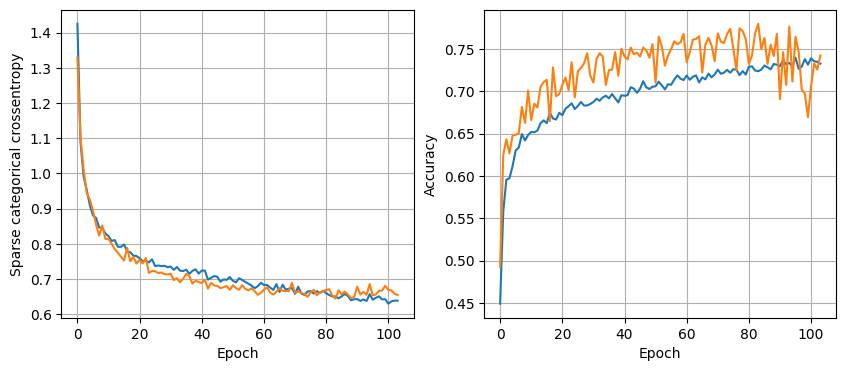

339/339 [==============================] - 1s 1ms/step

###### Training ######
              precision    recall  f1-score   support

           0       1.00      0.79      0.88      1204
           1       0.79      0.85      0.82      1204
           2       0.83      0.85      0.84      1204
           3       0.79      0.86      0.82      1204
           4       0.67      0.83      0.74      1204
           5       0.49      0.68      0.57      1204
           6       0.38      0.31      0.34      1204
           7       0.74      0.49      0.59      1204
           8       0.90      0.82      0.86      1204

    accuracy                           0.72     10836
   macro avg       0.73      0.72      0.72     10836
weighted avg       0.73      0.72      0.72     10836

47/47 [==============================] - 0s 2ms/step

###### Validation ######
              precision    recall  f1-score   support

           0       0.84      0.94      0.89        17
           1       0.95     

(<keras.src.engine.sequential.Sequential at 0x17a5004d750>,
 {'loss': [1.424937129020691,
   1.0883915424346924,
   0.9903367757797241,
   0.9529131054878235,
   0.9099811315536499,
   0.8807095289230347,
   0.8738420009613037,
   0.8466761708259583,
   0.8453378677368164,
   0.82953280210495,
   0.8222673535346985,
   0.8084620833396912,
   0.8110106587409973,
   0.7918571829795837,
   0.7916707396507263,
   0.7985351085662842,
   0.7793830037117004,
   0.7763810753822327,
   0.7666729688644409,
   0.7656583189964294,
   0.7594951391220093,
   0.7506651282310486,
   0.7524663805961609,
   0.7476668953895569,
   0.7563340663909912,
   0.7369502782821655,
   0.7388693690299988,
   0.7370200157165527,
   0.7378881573677063,
   0.7341270446777344,
   0.7358114123344421,
   0.7263911962509155,
   0.7345415949821472,
   0.7239282131195068,
   0.7232511043548584,
   0.7265319228172302,
   0.7152786254882812,
   0.723395049571991,
   0.7279406189918518,
   0.7158110737800598,
   0.72424727678

In [9]:
model, history, _ = tune_hyper_params_shallow_fnn_model(
    df=df,
    learning_rates=[0.001], 
    epsilons=[1e-07],
    beta_1s=[0.2, 0.4, 0.6, 0.8],
    beta_2s=[0.2, 0.4, 0.6, 0.8], # CANNOT BE EQUAL OR HIGHER THAN 1
    weight_decay=[None],
    clipnorm=[None],
    clipvalue=[None],
    patience=[10, 20]
)

## Manual tuning

Epoch 1/2000
85/85 - 1s - loss: 1.3689 - acc: 0.4635 - val_loss: 1.2951 - val_acc: 0.4759 - 935ms/epoch - 11ms/step
Epoch 2/2000
85/85 - 0s - loss: 1.0611 - acc: 0.5652 - val_loss: 1.0862 - val_acc: 0.5750 - 175ms/epoch - 2ms/step
Epoch 3/2000
85/85 - 0s - loss: 0.9719 - acc: 0.6059 - val_loss: 0.9769 - val_acc: 0.6546 - 154ms/epoch - 2ms/step
Epoch 4/2000
85/85 - 0s - loss: 0.9261 - acc: 0.6174 - val_loss: 0.9313 - val_acc: 0.6653 - 156ms/epoch - 2ms/step
Epoch 5/2000
85/85 - 0s - loss: 0.8915 - acc: 0.6213 - val_loss: 0.8603 - val_acc: 0.6814 - 156ms/epoch - 2ms/step
Epoch 6/2000
85/85 - 0s - loss: 0.8779 - acc: 0.6262 - val_loss: 0.8770 - val_acc: 0.6506 - 157ms/epoch - 2ms/step
Epoch 7/2000
85/85 - 0s - loss: 0.8548 - acc: 0.6413 - val_loss: 0.8459 - val_acc: 0.7028 - 171ms/epoch - 2ms/step
Epoch 8/2000
85/85 - 0s - loss: 0.8469 - acc: 0.6406 - val_loss: 0.8466 - val_acc: 0.6499 - 157ms/epoch - 2ms/step
Epoch 9/2000
85/85 - 0s - loss: 0.8228 - acc: 0.6507 - val_loss: 0.8221 - val_a

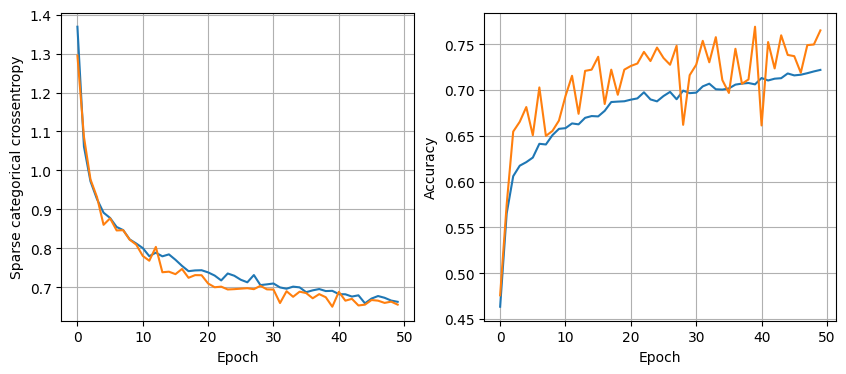

339/339 [==============================] - 0s 821us/step

###### Training ######
              precision    recall  f1-score   support

           0       1.00      0.75      0.86      1204
           1       0.77      0.93      0.84      1204
           2       0.86      0.90      0.88      1204
           3       0.82      0.82      0.82      1204
           4       0.71      0.78      0.75      1204
           5       0.55      0.71      0.62      1204
           6       0.68      0.36      0.47      1204
           7       0.80      0.76      0.78      1204
           8       0.86      1.00      0.93      1204

    accuracy                           0.78     10836
   macro avg       0.78      0.78      0.77     10836
weighted avg       0.78      0.78      0.77     10836

47/47 [==============================] - 0s 1ms/step

###### Validation ######
              precision    recall  f1-score   support

           0       0.83      0.88      0.86        17
           1       0.86   

In [7]:
model, _, _ = train_shallow_fnn_model(
                        df, 
                        epochs=2000, 
                        patience=10, 
                        units=512,
                        dropout_rate=0.2,
                        learning_rate=0.0015,
                        verbose=2,
                        epsilon = 1e-07,
                        beta_1 = 0.9,
                        beta_2 = 0.999,
                        weight_decay = None,
                        clipnorm = None,
                        clipvalue = None,
                        disable_print_report=True,
                        disable_save=True)

print_results(model)

In [ ]:
y_pred = model.predict(x_test).argmax(axis=1)

result = test_df 
result["predicted_country_risk"] = y_pred

distribution = result.groupby(["country_risk", "predicted_country_risk"]).size().reset_index().rename(columns={0: 'count'})
distribution["difference"] = distribution["country_risk"] - distribution["predicted_country_risk"]
print(distribution)

In [ ]:
plt.bar(distribution["difference"], distribution["count"])
plt.xlabel("difference")
plt.ylabel("count")
plt.show()